## DSC650-T301 Big Data (2235-1)
## 5/24/2023
## Joshua Greenert

In [1]:
# Using section 8.4 in Deep Learning with Python as a guide, implement a variational autoencoder using the MNIST data set
# and save a grid of 15 x 15 digits to the results/vae directory. If you would rather work on a more interesting dataset,
# you can use the CelebFaces Attributes Dataset instead.
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
import os

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create a directory to save the results
result_dir = "results/vae"
os.makedirs(result_dir, exist_ok=True)

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [2]:
# Reshape and normalize the training/test data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

In [3]:
# Define the VAE architecture
input_dim = 784
latent_dim = 20
intermediate_dim = 256

inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim, activation='softplus')(h)

In [4]:
# Reparameterization trick
class Sampling(Lambda):
    def __init__(self, name='sampling'):
        super(Sampling, self).__init__(self.sampling, name=name)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= input_dim
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
# Use the sampling method and set Dense options
# Create encoder model
encoder_inputs = Input(shape=(input_dim,), name="encoder_input")
x = Dense(intermediate_dim, activation="relu")(encoder_inputs)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Create decoder model
latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
x = Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = Dense(input_dim, activation="sigmoid")(x)
decoder = Model(latent_inputs, outputs, name="decoder")

In [6]:
# Define the custom loss function
# def vae_loss(x, x_decoded_mean):
#     xent_loss = tf.keras.backend.mean(binary_crossentropy(x, x_decoded_mean), axis=-1)
#     kl_loss = -0.5 * tf.keras.backend.mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
#     return xent_loss + kl_loss

In [11]:
# Combine them to create VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Train the VAE
for epoch in range(20):
    for x_batch, _ in train_dataset:
        losses = vae.train_step(x_batch)
        print(f"Losses: {losses}")

    print(f"Epoch {epoch+1}/{20} - Training complete")

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=535.2921>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=535.19727>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0948622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=520.564>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=520.3951>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.16893403>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=502.20978>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=501.90298>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.30680624>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=482.4636>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=481.96893>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.49465108>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=455.75015>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=211.70412>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=208.46552>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2385955>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=201.31256>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=197.86899>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4435692>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=212.1974>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=208.52533>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6720777>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=220.5631>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=216.75697>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8061223>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=206.78233>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=174.61185>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=171.07071>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.54114>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=168.39897>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=164.79832>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6006463>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=165.63724>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=161.9409>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6963296>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=166.59383>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=162.86934>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7244866>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=166.47081>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=158.19489>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=153.33176>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.863131>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=152.97774>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=148.15953>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8182>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=150.73396>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=146.40685>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3271217>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=142.86847>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=138.61005>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.258418>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=151.17744>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=147

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=140.77231>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=136.85518>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9171352>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=149.3506>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=145.25742>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.093179>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=144.77853>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=140.35324>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.425292>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=140.22372>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=136.20721>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0165105>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=132.70847>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=129.96048>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=126.01645>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9440339>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=132.28993>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=128.73997>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.549954>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=133.12204>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=128.74481>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.377234>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=128.77106>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=123.97436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.796706>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=126.22693>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=127.67948>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=123.75358>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9259057>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=125.77973>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=122.16112>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6186154>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=134.25525>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=130.70702>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5482259>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=124.86048>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=120.52839>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3320937>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=124.92012>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, nump

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=127.81885>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=123.20009>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6187615>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=125.57479>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=120.263054>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.311736>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=121.674255>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=116.745415>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9288406>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=121.055374>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=116.609535>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4458394>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=116.93504>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=113.27651>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=109.53983>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7366767>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=114.19897>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=109.54012>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6588416>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=113.40177>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=108.410614>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9911556>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=109.41072>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.48544>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9252768>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=118.45033>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, num

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=116.23462>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=111.32117>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9134493>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=117.75065>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=112.72482>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.025824>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=118.29159>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=112.9373>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.354285>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=107.99328>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=102.95385>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.039428>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=107.41461>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=10

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=110.67557>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=105.68014>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.995433>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=102.742>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=98.01449>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.727507>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.53504>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=100.05868>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4763656>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.722435>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=100.23914>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4832926>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=106.16873>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=10

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.64283>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.6868>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.956035>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=120.54301>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=116.251915>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.291091>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=103.63026>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=98.71031>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9199433>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=103.89403>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=99.33173>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.562293>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.29927>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.330

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=106.52184>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=102.08682>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.435022>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=100.48379>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.927826>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5559645>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=102.58755>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=97.887566>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.699983>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=97.43359>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.87701>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5565834>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=101.94243>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=97

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=98.47985>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.92349>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.556359>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=106.04234>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=101.279465>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.762877>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=105.85187>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=101.13733>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7145367>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.844574>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=100.063156>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.781415>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.12154>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=101.692444>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=97.605515>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0869303>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=108.043884>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=103.49519>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.548694>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=104.865845>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=100.25365>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.612195>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=96.8163>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.07357>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7427316>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.791695>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=101.550064>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=96.47341>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0766497>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=102.92263>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=97.9082>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.01443>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=99.92053>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.18141>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.739122>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=96.183205>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.696144>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4870596>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.82151>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.063

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.780075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.03976>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.740321>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.65167>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.38744>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2642283>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.90335>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.742836>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1605177>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.36795>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.41056>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9573913>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.67311>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.007

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.06943>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.43505>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6343765>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.00893>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.80987>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.199061>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.402275>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.927315>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.474963>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.90174>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.417305>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.484437>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=97.381355>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.128

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.02816>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.85089>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.1772676>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.76835>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.58919>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.179158>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.419075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.99081>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4282675>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=95.823>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.07664>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.74636>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.71976>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.51556>, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.24573>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.33711>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9086165>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.542694>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.83074>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.711955>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.64045>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.74675>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8936973>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.69252>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.77937>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.913146>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.3636>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.66743>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.49066>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.72485>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.765811>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.711784>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.99289>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7188935>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.91071>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.34749>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5632224>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.192215>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.78472>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.407491>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=92.26867>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.1929

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.121155>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.72916>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3919997>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.32448>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.12385>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.20063>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.754684>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.605286>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1494007>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.49752>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.24305>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.254468>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.74161>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.0859

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=93.96745>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.62994>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3375196>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.248856>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.871216>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.377641>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=96.1902>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.72627>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.463931>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.74514>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.6344>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1107435>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.424934>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.38998

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.08103>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.50937>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.57166>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.67181>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.109566>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.562238>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.08111>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.6194>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4617066>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.31808>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.74112>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5769606>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.85712>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.75462>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.67611>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.98415>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.691954>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.489525>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.67196>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8175645>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.805016>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.457306>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.347712>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.76612>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.45237>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3137517>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.8923>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.3254

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.28912>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.53612>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7530074>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.12099>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.37262>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7483697>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.26911>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.80101>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.468102>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.93334>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.51894>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.414397>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.04131>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.38345>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.7035>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.14952>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.553975>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.53211>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.306526>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.225585>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.04405>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.80508>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2389727>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=98.552055>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.31602>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.236037>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.026436>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.71827

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=94.44212>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.26695>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.17517>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.3011>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.00577>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.295335>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.817276>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.61617>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.201106>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.29668>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.0507>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.245976>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.3882>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.128624>, 'k

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.95053>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.92814>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.02239>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.47448>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.679214>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7952645>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.67572>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.85949>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.81623>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.64588>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.772964>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8729172>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.62073>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.328545

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.44369>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.457436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9862485>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.154976>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.15648>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.998499>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.675964>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.23136>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4446044>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.55104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.1278>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.423239>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.43222>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.2256

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.61731>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.45061>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1667013>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.98102>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.062126>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9188905>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.698166>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.45277>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.245397>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.8955>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.6889>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2065935>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.89402>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.7225>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.801186>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.86788>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9333024>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.361694>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.39905>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9626427>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.06895>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.78903>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.279912>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.575195>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.33133>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.243863>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.97379>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.534

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.64802>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.42487>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2231455>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.8785>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.78853>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.089976>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.4884>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.440956>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0474443>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.30082>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.34255>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.958264>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.38959>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.41122>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.221756>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.55784>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6639183>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.229>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.37055>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8584409>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.722565>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.65128>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.071283>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.296875>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.20684>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0900383>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.67274>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.4755

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.87839>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.59298>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.285411>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.82504>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.55507>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2699704>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.003914>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.7991>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2048116>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.47196>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.17156>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.300397>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.60071>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.64777>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.10243>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.05911>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.043317>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.234665>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.11484>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1198244>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.98613>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.59862>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3875136>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.76797>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.283676>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4842925>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.043106>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.97

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.706406>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.76585>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9405587>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.82303>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.426926>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.396102>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.99469>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.60269>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.391998>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.75765>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.55739>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.200263>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.07858>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.91828

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.167786>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.9328>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.234982>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.560684>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.37802>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.182659>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.682076>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.422485>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.259591>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.678055>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.7174>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9606571>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.01136>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.0276

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.33592>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.56591>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7700088>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=89.35595>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.40974>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9462152>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=90.24864>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.27679>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9718585>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.577805>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.541794>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0360084>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.406784>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.4

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.153595>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.1645>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9890945>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.60672>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.38719>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.219532>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.00679>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.94505>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.06174>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.281265>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.45848>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8227806>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.94551>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.33751>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.06968>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.05111>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.018573>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.61185>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.51887>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0929756>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.002945>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.19696>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8059878>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.04721>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.2186>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.828617>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.6547>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.469>, '

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.5255>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.50488>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0206122>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.41917>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.148506>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.270663>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.914764>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.906296>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.008465>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.76729>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.98125>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.78604>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.18272>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.09577>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.88376>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.07625>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8075116>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.81466>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.21689>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.597774>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.34406>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.59842>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7456455>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.39213>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.62048>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7716472>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.22209>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.14195

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.05605>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.84345>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2126017>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.93403>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.64651>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2875185>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.002495>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.804375>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.198117>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.33549>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.158936>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1765513>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=86.62097>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.62

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.45951>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.54326>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.916251>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.14912>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.90238>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2467318>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.22746>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.187614>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0398493>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.34925>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.791595>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5576522>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.054474>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.31

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.172646>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.14196>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0306826>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.79027>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.76874>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0215273>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.589424>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.51501>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.074416>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.55052>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.74385>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8066697>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.68878>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.966

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.53627>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.561104>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9751637>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.31297>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.09269>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2202845>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.75838>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.49325>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2651315>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.08905>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.17935>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9096973>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.97997>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.073

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.28394>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.14074>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.143207>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.39004>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.2391>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.150937>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.50037>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.47659>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0237722>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.03599>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.063225>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9727654>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.60493>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.51489>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.19302>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.187874>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0051527>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.62345>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.885895>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7375557>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.47962>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.71718>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.762445>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=91.04237>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=87.185684>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8566928>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.03406>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.12

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.15276>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.40122>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7515445>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.69069>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.81239>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8782997>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.869255>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.96737>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.901883>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.22117>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.32745>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8937135>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.865746>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.895

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.03072>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.406906>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6238174>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.90877>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.918564>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9902024>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.19768>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.24604>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9516392>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.3735>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.2837>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.089797>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.555885>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.7775

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.045425>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.36865>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6767724>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.41535>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.7181>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6972516>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.21279>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.25292>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9598663>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.41567>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.44665>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9690254>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.26722>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.4385

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.88189>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.04119>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.840695>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.7593>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.11402>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6452794>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.8899>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.99034>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.899559>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.74472>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.85825>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.886465>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.10507>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.2512>, 'k

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.804344>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.89458>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9097695>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.70079>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.824646>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8761418>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.18465>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.18851>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9961421>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.64424>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.65247>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9917653>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.76912>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.80

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.79931>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.0439>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.755408>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.181046>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.50121>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6798337>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.135765>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.42879>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7069812>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.60468>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.8542>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7504787>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.05778>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.37715

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.38188>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.60149>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7803962>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.86926>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.00396>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8653023>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.65106>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.02047>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6305892>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.22333>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.59872>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6246078>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.48143>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.7253

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.82557>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.90327>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9222991>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.41048>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.72227>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.688212>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.66762>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.04624>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6213799>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.41057>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.73483>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.675733>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.58653>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.73309>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.48317>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.354515>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1286573>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.399796>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.3296>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0701957>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.57768>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.67292>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9047656>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.69254>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.91969>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7728474>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.660416>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.90

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.94174>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.926476>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0152626>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.35703>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.599106>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.75793>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.173645>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.71601>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4576354>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=85.20921>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.36292>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8462868>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.067955>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.15

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.03877>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.90661>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.132165>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.36763>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.19338>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.174244>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.05019>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.206665>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8435254>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.77223>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.09295>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6792846>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.264984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.5410

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.70282>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.030495>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6723228>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.49906>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.79008>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7089837>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.44316>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.54655>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8966172>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.903534>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.88832>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.015209>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.584595>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.73

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.35026>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.722984>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6272702>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.75108>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.41308>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3380089>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.84985>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.24432>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6055274>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.44639>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.83801>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6083786>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.80656>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.093

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.56482>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.81132>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7535045>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.07487>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.33061>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7442539>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.10072>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.56116>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5395622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.45463>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.04317>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.411462>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.87666>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.77001

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.922104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.116455>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8056462>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.512955>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.99722>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.515728>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.13355>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.67567>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4578846>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.75552>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.92946>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.826067>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.193634>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.38

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.5367>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.713715>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8229814>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.13288>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.31912>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8137612>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.7133>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.92612>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7871838>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.39794>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.663956>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7339892>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.47393>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.8433

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.60493>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.05896>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5459676>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.375175>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.799576>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.575602>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.6642>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.0364>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6277976>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.54615>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.010574>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5355747>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.39458>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.7464

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.957016>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.342804>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6142159>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.98309>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.31579>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6673045>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.501976>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.74947>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7525012>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.268654>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.716835>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5518157>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.816864>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.56939>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.79602>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7733688>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.71005>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.14502>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5650368>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.93089>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.43436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4965377>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.206825>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.68776>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.519067>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.96624>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.2695

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.95574>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.25116>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7045815>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.489105>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.53741>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9516945>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.982605>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.06861>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9139926>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.227234>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.45553>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7717083>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.264656>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.586945>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.99141>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5955327>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.64382>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.21439>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4294255>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.14581>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.50402>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6417909>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.096214>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.335884>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7603288>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.352104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.0594>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.40304>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6563618>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.593956>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.93975>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.654208>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.86795>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.3018>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.566143>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.068275>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.51436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5539193>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.7946>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.02877>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.54756>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.94916>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5984054>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.00587>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.36863>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6372344>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.14533>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.508415>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6369152>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.52316>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.835815>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.687346>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.890205>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.35

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.15796>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.778625>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.379333>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.74961>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.326256>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.423357>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.80627>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.33135>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4749177>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.94803>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.190834>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7571945>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.11578>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.402

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.989044>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.484695>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.504348>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.47907>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.7947>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6843724>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.27129>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.54502>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7262719>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.19323>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.5679>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6253288>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.7773>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.1644>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.90854>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.34331>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5652306>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.61815>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.19558>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4225707>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.732414>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.090004>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6424084>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.50317>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.85812>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6450424>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.95391>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.32

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.316055>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.59153>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.724523>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.88431>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.17896>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7053413>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.55199>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.85108>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7009041>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.30989>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.6409>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6689873>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.194214>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.6337

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.43973>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.98117>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4585576>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.24503>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.67386>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.571176>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.198204>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.55167>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6465373>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.06986>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.58224>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4876258>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.407074>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.898

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.30728>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.65056>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6567245>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.21634>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.74542>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.470916>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.6562>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.20702>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.449173>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.56075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.9651>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5956466>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.27217>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.67208>, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.50578>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.838>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6677818>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.82287>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.13083>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.69204>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.5415>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.875465>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.666031>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.72352>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.2274>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.496116>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.89829>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.461136>, 'k

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.31244>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.56185>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7505836>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.94698>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.42445>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5225272>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.32004>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.777725>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.542315>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.14514>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.551254>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5938911>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.38118>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.579

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.915>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.36153>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5534725>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.93589>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.27358>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.662309>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.12396>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.17632>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9476414>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.19455>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.42458>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7699668>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.674614>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.10457>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.87367>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.423515>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4501548>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.83439>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.20262>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.631766>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.34471>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.64256>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7021477>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.87979>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.201965>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6778297>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.3067>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.6436

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.74302>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.30462>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.438399>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.51181>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.02018>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.491628>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.11827>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.59746>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5208137>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.047226>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.39242>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6548111>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.97052>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.25648

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.06687>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.34838>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.718491>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.837105>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.36452>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.472588>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.14971>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.912575>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.237135>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.13656>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.69134>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.445221>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.10999>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.70088>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.374886>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.72006>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6548252>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.98218>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.43467>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.547512>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.98691>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.44943>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5374737>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.195496>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.78366>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4118316>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.01943>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.718

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.74217>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.18851>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5536652>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.028656>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.35953>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6691296>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.90349>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.30023>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6032555>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.43811>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.05597>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.382141>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.526344>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.195

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.61458>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.00067>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6139073>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.33315>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.82467>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5084865>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.89483>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.510254>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3845775>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.903625>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.25215>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.651472>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.4244>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.7346

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.368515>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.79992>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.568599>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.24869>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.82266>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4260285>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.350975>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.91859>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4323878>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.59862>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.10459>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4940262>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.56044>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.008

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.73522>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.00789>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7273319>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.56233>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.81252>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.749808>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.52499>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.13369>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3912988>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.97924>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.78459>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.19465>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=88.1646>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=84.66039>, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.52934>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.05446>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4748855>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.379105>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.93345>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4456544>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.57363>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.1089>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4647317>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.134445>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.642166>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4922783>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.46269>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.81

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.562355>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.03252>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5298386>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.44667>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.86793>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5787444>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.34862>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.77786>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5707543>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.92027>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.45417>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4661026>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.17517>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.790

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.44874>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.12582>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3229237>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.09473>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.440765>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.653962>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.69757>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.96714>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7304337>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.41842>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.91071>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5077043>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.438835>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.947

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.12456>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.30951>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.815045>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.47102>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.624344>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8466823>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.46109>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.85129>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6098003>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.01502>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.53593>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4790962>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.314476>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.809

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.42791>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.97658>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4513295>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.1541>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.58136>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5727367>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.143295>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.52542>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.617871>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.96696>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.429436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5375228>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.303116>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.693

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.14327>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.799774>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3434958>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.69795>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.25547>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4424834>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.82826>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.40281>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4254506>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.15511>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.702286>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4528308>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.69994>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.25

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.213196>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.97949>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2337036>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.813324>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.10882>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7045085>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.04189>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.35985>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6820455>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.61107>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.10988>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.501191>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.1122>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.5555

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.12966>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.546684>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.582975>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.25341>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.740204>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5132072>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.760124>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.43642>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3237042>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.75784>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.47468>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2831619>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.81482>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.26

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.5328>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.97263>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5601673>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.63745>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.098045>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5394084>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.52446>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.07289>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4515681>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.11193>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.78581>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.326121>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.95476>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.39152

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.08814>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.65266>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4354892>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.85426>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.51323>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.341037>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.50076>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.06638>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4343758>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.827805>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.333046>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4947548>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.50424>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.136

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.57095>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.07485>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4960976>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.668076>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.14398>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5240948>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.02412>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.36071>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6634088>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.97761>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.28968>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6879249>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.856766>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.49

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.307884>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.98337>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3245196>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.09743>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.80271>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.294714>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.3966>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.96254>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4340622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.264824>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.880745>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3840766>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.550545>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.95

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.712906>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.26191>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4509926>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.0536>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.433044>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.620549>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.21301>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.577736>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6352756>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.694984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.16127>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.533711>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.27676>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.835

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.43266>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.66345>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7692077>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.56221>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.94049>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.62172>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.27191>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.81334>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4585717>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.73162>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.44826>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2833626>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.99426>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.397354

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.17092>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.62622>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5446982>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.00752>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.42886>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5786605>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.6055>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.05281>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5526874>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.817894>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.27135>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5465493>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.91349>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.3104

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.09175>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.66095>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4308002>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.70065>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.25228>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.448372>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.034454>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.60282>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4316368>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.00775>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.53924>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.468511>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.80026>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.46766

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.96354>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.682884>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2806544>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.85818>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.541504>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3166733>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.61285>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.097496>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5153527>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.629036>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.11916>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5098717>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.37235>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.96694>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.61393>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3530128>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.93697>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.46399>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4729843>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.69796>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.160416>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5375476>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.57306>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.12687>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4461906>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.22149>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.766

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.64362>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.19324>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4503887>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.94104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.40201>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.539032>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.34568>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.93196>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4137168>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.38536>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.10661>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2787476>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.84575>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.39569

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.22619>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.80668>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.419513>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.36231>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.01988>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3424325>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.131195>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.901695>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.229496>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.482315>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.20075>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.281564>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.999664>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.660

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.512695>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.13601>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3766885>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.08535>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.492744>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5926042>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.887825>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.26283>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6249912>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.68126>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.051125>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6301353>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.25424>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.0143>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.72932>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.284982>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.70261>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.19842>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.504187>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.579605>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.14963>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4299748>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.95122>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.414986>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5362334>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.90591>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.46147

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.99886>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.51521>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4836526>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.93492>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.51862>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.416298>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.56411>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.11081>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4532971>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.673355>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.1737>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4996593>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.24269>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.74628

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.85449>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.5863>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2681916>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.134476>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.720825>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4136543>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.76557>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.36152>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.404056>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.32806>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.79664>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5314178>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.92447>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.3924

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.71791>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.28258>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4353306>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.08783>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.621635>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4661903>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.235596>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.813416>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4221787>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.58292>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.1123>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4706216>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.3325>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.983

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.880455>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.47614>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4043145>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.14963>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.7369>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.412725>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.22468>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.87366>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.351022>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.62966>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.29319>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3364716>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.510345>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.04375

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.150444>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.75572>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3947206>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.48642>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.06045>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4259708>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.41615>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.127556>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2885997>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.63381>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.33973>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2940826>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.22836>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.90

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.93275>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.46453>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4682133>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.203316>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.75739>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4459229>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.843414>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.329796>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.513617>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.69625>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.37186>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3243918>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.3848>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.227

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.83873>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.54262>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2961159>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.88709>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.68661>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2004838>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.44788>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.85396>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.593928>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.889175>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.328804>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5603688>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.435715>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.03

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.602585>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.19961>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4029775>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.544685>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.04783>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.49686>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.35219>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.949875>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4023101>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.70147>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.45548>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.24599>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.58732>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.38309

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.183174>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.71789>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4652889>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.456604>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.011734>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.444867>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.129074>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.76146>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3676143>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.54021>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.28523>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.254973>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.62367>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.19

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.52797>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.16022>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3677497>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.87095>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.62086>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2500916>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.52435>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.17916>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3451896>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.79366>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.38256>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4110997>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.39005>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.0754

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.915825>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.575005>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.340817>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.11996>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.7344>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3855617>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.24895>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.7706>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4783502>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.49869>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.1792>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3194923>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.77343>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.4777>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.2008>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.80522>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3955746>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.28416>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.859604>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4245534>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.84881>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.43278>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4160323>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.78075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.36385>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4168968>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.85484>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.4112

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.7632>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.439674>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.323527>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.50233>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.145134>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3571954>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.763824>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.38721>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.376617>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.935455>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.43697>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4984794>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.79319>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.287

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.02502>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.57235>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4526658>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.913025>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.57693>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3360982>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.05703>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.78995>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2670841>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.51103>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.15034>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3606956>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.12031>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.643

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.74492>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.36385>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3810687>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.76263>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.43994>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3226883>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.16942>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.842026>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3273895>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.8936>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.43502>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.458583>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.22157>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.75841

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.06978>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.70772>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3620567>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.72742>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.345726>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3816898>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.49758>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.13136>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.36622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.80215>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.40689>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.395258>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.06656>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.81097>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.30722>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.005486>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3017387>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.36066>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.97921>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3814476>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.22859>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.90013>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3284638>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.86248>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.59728>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2652001>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.54782>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.363

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.31919>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.00283>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.316359>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.57254>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.28013>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.292408>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.83414>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.52986>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3042755>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.013145>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.7811>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2320466>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.030525>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.77486

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.69658>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.36438>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3321967>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.044945>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.74379>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3011537>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.50058>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.19255>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.30803>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.29852>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.89886>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3996644>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.918846>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.4441

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.56861>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.12676>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.441852>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.15991>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.728035>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.431874>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.558945>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.219475>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.339473>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.762856>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.48492>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2779362>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.046875>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.74

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.9899>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.587776>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4021237>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.68463>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.271095>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4135323>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.15268>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.772514>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3801684>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.24711>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.900097>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.347013>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.65615>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.33

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.35405>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.05572>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2983353>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.459816>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.17737>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2824452>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.989944>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.78542>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2045243>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.625916>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.21642>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4094892>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.53916>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.49362>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.090576>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4030461>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.98427>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.643776>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3404915>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.62212>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.28027>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3418517>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.263405>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.88658>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.37682>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.09389>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.771

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.867455>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.70693>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1605215>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.18485>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.064766>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1200843>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.88792>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.65253>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2353883>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.974464>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.61038>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3640842>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.8881>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.53

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.18809>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.814>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.374083>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.92721>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.54337>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3838363>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.86096>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.50981>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3511524>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.87848>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.485825>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3926568>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.09262>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.74887>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.94647>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.60752>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3389518>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.47984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.097153>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.382687>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.89717>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.63923>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2579422>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.71322>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.42808>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2851434>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=83.237854>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.901

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.00637>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.65891>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3474555>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.548645>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.11115>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.437493>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.0512>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.66255>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3886483>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.839485>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.60458>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2348983>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.70748>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.3971

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.49609>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.15298>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3431206>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.99144>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.62514>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3663063>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.69464>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.38367>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.310978>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.22092>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.835335>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3855813>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.97211>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.6145

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.29152>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.02139>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2701283>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.048706>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.71535>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3333611>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.59088>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.27108>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3198032>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.06232>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.729065>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3332534>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.75888>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.38

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.537766>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.183395>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3543708>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.73543>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.37494>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3604856>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.76199>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.40171>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.360286>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.00615>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.68305>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3230996>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.70949>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.503

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.7326>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.36324>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3693557>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.2508>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.859955>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3908477>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.181145>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.864395>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3167481>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.18587>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.9306>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.255263>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.88404>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.62742

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.36386>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.082664>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.281194>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.66981>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.37547>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2943351>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.499146>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.18769>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3114543>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.36796>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.0535>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3144639>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.36344>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.0775

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.78328>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.40326>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3800225>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.246>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.80183>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4441726>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.77204>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.401474>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.370565>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.0906>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.731514>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.359085>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.9224>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.654694>,

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.35341>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.02452>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3288848>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.684586>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.337616>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3469734>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.16469>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.82002>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3446655>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.32236>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.934814>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3875432>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.14239>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.9

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.717354>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.36774>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3496146>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.85051>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.51374>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3367698>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.23804>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.862885>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3751552>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.46605>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.15714>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.308906>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.800575>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.62

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.63766>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.383995>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2536635>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.33996>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.05794>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2820182>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.45389>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.1706>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2832901>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.79701>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.53251>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2645001>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.5936>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.29581

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.79375>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.50114>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2926064>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.141884>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.82211>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3197677>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.07935>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.728546>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3508058>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.44846>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.11805>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.330412>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.0175>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.7318

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.98372>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.63778>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3459358>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.726204>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.44561>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2805939>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.14285>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.79311>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.349736>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.76056>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.32928>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4312787>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.47128>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.0338

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.814804>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.558212>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2565925>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.12095>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.81215>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.308803>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.120964>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.81948>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3014863>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.10384>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.797424>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.306418>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.90526>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.56

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.50651>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.095024>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4114845>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.87184>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.559814>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3120239>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.13878>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.8436>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2951844>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.6103>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.34695>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2633495>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.21798>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.0250

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.30132>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.94795>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3533683>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.14232>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.89481>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.247509>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.693924>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.37865>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3152757>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.152374>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.89074>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2616353>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.71808>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.397

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.36075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.07717>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.283577>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.55202>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.22624>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3257766>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.48898>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.14628>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3427086>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.794846>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.45647>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.338375>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.98717>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.71352

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.23604>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.95999>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2760499>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.95556>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.67803>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2775238>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.84793>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.58006>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2678714>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.25493>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.02244>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.23249>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.59024>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.314674

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.47854>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.15788>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3206565>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.88472>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.50826>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3764586>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.60542>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.28998>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3154464>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.86519>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.545784>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3194058>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.62749>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.384

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.9158>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.68099>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2348106>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.10297>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.85796>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2450035>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.06535>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.76679>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2985604>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.3567>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.03943>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.317266>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.860245>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.54053>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.96484>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.60473>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3601143>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.989136>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.69076>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.298378>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.53414>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.21281>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3213344>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.07236>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.843704>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.228656>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.44208>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.0854

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.80277>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.4756>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.327169>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.6612>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.412834>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2483642>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.351494>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.0538>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2976894>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.56431>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.20792>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.356395>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.082634>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.699104

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.52016>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.234116>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2860382>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.320625>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.05683>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2637908>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.56927>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.33317>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2361016>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.03799>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.771225>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2667649>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.2189>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.93

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.3014>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.00372>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2976737>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.79938>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.45695>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.342427>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.75464>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.42244>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3321984>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.978874>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.6124>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3664765>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.61149>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.32058>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.99247>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.74837>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.244102>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.98192>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.80298>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1789367>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.97221>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.679855>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2923546>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.592575>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.24788>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.344693>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.156944>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.891

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.36542>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.13018>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2352371>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.73236>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.44502>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2873397>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.23906>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.96576>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.273304>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.03756>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.795616>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2419465>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.633896>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.391

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.68926>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.34214>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3471189>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.40811>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.10846>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2996528>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.48568>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.12293>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3627484>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.38924>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.0042>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3850296>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.35855>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.07986

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.04328>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.68184>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.361444>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.02285>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.6752>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3476498>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.69994>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.45326>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2466812>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.2966>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.12084>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1757605>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.8533>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.69397>, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.17378>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.85294>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3208375>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.28013>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.899284>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3808453>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.934525>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.61702>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3175018>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.898674>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.60671>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.291959>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.50753>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.27

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.4653>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.26374>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2015572>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.65773>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.45875>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1989803>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.458275>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.23337>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2249045>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.782104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.60844>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1736717>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.75216>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.425

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.329994>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=62.99845>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3315442>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.87696>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.414795>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4621665>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.33442>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.80851>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5259101>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.96625>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.74773>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2185235>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.21309>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.92

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.42443>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.16441>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2600162>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.97736>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.70244>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2749252>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.90578>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.57627>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.329507>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.89778>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.47796>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4198196>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.175705>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.7750

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.50353>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.18482>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3187127>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.70502>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.39036>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3146558>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.88945>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.63739>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2520576>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.843285>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.63321>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2100759>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.25317>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.993

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.46355>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.206314>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2572296>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.33028>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.178474>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1518002>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.68486>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.48343>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2014275>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.23769>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.974594>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.263102>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.29087>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.98

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.36678>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.11555>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2512383>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.221085>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.964645>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2564385>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.55196>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.227745>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3242188>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.04625>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.77639>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.269858>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.2425>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.991

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.30595>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.05902>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2469227>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.003204>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.68724>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3159611>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.189674>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.03152>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1581573>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.41957>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.1752>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2443657>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.9806>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.6242

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.00691>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.83842>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.168494>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.34953>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.107376>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2421536>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.157616>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.903366>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2542503>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.8604>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.63856>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.221843>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.20908>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.9981

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.30415>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.88362>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.420529>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.00961>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.62052>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.38909>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.77488>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.487755>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.287125>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.081314>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.75181>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3295074>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.79941>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.46068>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.4488>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.13995>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.308847>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.47721>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.09332>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3838897>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.8264>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.53032>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2960792>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.03961>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.858536>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1810794>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.59364>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.46612>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.71901>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.32504>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3939629>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.72385>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.36461>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3592339>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.31463>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.922356>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3922753>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.527756>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.14808>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.379676>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.17504>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.882

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.13637>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.84066>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2957046>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.31881>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.045006>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2738068>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.85241>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.60856>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.243854>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.57387>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.319275>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2545896>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.707375>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.44

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.28417>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.01131>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.272862>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.57454>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.25269>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3218474>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.20465>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.931786>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2728639>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.85754>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.75379>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.103747>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.71527>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.48917

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.74344>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.46061>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2828324>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.59039>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.30898>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2814136>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.37153>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.101074>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2704563>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.99092>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.71491>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.27601>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.074104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.7480

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.90243>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.8366>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0658264>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.574>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.42391>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1500828>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.560326>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.305435>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.254893>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.46871>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.239235>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2294745>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.86192>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.47925

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.8025>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.52145>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2810485>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.44775>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.189125>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.258618>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.23004>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.9314>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.298642>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.549065>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.27232>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2767441>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.06956>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.82003>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.651596>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.410965>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2406318>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.55818>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=62.29615>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2620301>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.73065>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.550224>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.180428>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.242096>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.041046>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.201051>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=81.8524>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.57

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.34647>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.98461>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3618622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.88191>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.566887>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3150268>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.704094>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.318726>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.385369>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.54659>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.18526>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3613353>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.439415>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.444984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.10969>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3352997>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.69174>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.511856>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1798828>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.58719>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.32731>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2598832>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.94365>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.63147>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3121784>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.54043>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.28

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.678566>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.44679>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2317734>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.45862>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.18864>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.269978>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.94163>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.67699>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2646422>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.81572>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.57207>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.24365>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.85758>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.62952>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.00705>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.798546>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.208503>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.25134>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.11519>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1361578>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.97619>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.83335>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1428351>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.880516>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.65999>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2205288>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.53351>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.344

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.91617>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.6419>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2742653>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.3486>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.06643>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.282177>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.93906>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.72582>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2132332>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.00065>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.826805>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1738431>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.55533>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.376724

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.65819>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.418945>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2392387>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.17791>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.876854>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3010573>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.17109>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.889984>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2811043>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.72402>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.459724>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2642999>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.00523>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=62.

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.06338>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.80943>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.253947>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.79793>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.64409>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1538386>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.190506>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.972824>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.21768>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.54776>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.36581>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1819553>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.712585>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.5398

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.05635>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.95343>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1029184>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.04617>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.826416>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2197578>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.40831>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.14258>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2657318>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.49708>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.21827>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.27881>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.8752>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.59003>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.57761>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.34672>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.230889>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.334435>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.0582>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2762408>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.49232>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.28999>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2023282>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.56984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.43498>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.134856>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.21637>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.060585

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.91666>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.71681>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.199841>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.85729>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.64174>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2155538>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.62581>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.41821>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2075953>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.01427>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.80233>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2119389>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.59103>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.38229

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.7829>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.54901>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2338898>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.452614>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.239716>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2128968>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.48206>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.2146>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2674644>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.97782>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.700676>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2771454>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=80.17653>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.901

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.6189>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.30793>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.310968>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.55521>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.32671>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.228492>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.82216>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.53403>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2881331>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.62952>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.27952>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.349998>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.2619>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.91599>, '

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.66795>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.3847>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2832603>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.65708>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.38035>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2767365>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.4331>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.151825>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2812698>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.968925>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.78528>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.183649>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.74321>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.56712

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.6281>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.38042>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2476814>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.60045>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.396965>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2034798>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.84662>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.605576>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2410426>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.426094>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.18395>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2421448>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.356064>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.1

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.32395>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.105034>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2189155>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.69578>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.42662>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.269155>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.51566>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.225006>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2906559>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.56449>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.38056>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1839325>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.70158>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.534

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.215904>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.111946>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1039608>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.71047>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.44181>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2686622>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.30003>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.060715>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.239317>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.00432>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.74234>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2619793>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.74008>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.52

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.62695>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.31611>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3108406>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.34679>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.10818>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.238606>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.69812>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.39055>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3075714>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.13868>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.885605>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2530727>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.177444>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.926

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.963554>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.70167>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2618835>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.76632>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.58108>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1852393>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.43126>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.23965>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1916099>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.81688>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.54661>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2702718>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.74072>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.445

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.01616>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.63786>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3782928>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.7263>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.28329>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4430168>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.228165>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.06789>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1602757>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.48356>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.25606>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2275023>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.16705>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.9185

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.36889>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.08507>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2838225>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.23259>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.85736>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.375229>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.16127>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.80197>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3593>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.14779>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.8607>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.287088>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.636566>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.43878>, '

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.566696>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.20651>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3601813>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.84236>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.56474>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2776217>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.82455>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.58212>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.242424>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.76842>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.57747>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1909497>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.40758>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.1869

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.51375>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.238144>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2756019>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=78.051704>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.79906>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.252645>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.67275>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.46559>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2071636>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.26228>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.02513>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2371533>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.50089>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.242

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.09338>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.91536>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1780245>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.22758>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.998184>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.229391>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.05857>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.79875>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2598166>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.6709>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.404564>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2663372>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.89923>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.6051

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.3815>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.09707>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2844338>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.66836>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.39165>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2767074>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.1185>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.95824>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1602626>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.93391>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.75078>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1831317>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.68993>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.57028>

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.9113>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.79007>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1212277>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.59705>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.41685>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1802027>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.923256>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.62665>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2966084>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.50089>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.26378>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2371154>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.696144>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.433

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.270454>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.011116>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.259336>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.04544>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.76599>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2794526>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.01202>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.76224>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2497795>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.889984>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.732925>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.157062>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.46931>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.28

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.21988>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.89562>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3242536>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.50802>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.226204>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2818112>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.08929>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.81928>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2700036>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.72135>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.47127>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2500863>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.66022>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.500

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.16597>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.879036>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2869332>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.44761>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.142395>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3052132>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.61068>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.24889>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3617826>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.46541>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.228836>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.236571>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.73274>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.59

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.10738>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.85792>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2494671>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.72026>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.548035>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1722226>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.52337>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.35483>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1685388>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.28238>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.08069>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.201694>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.07743>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.8659

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.45154>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.11759>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3339431>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.21924>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.875534>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3437042>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.32527>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.17968>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.145595>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.10781>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.093525>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0142865>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=82.91879>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=79.667

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.331345>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.14791>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1834302>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=76.84104>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.53812>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3029258>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.83555>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.622696>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.212854>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.81887>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.676254>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1426165>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.508766>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.3

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.310234>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.974815>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3354201>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.199554>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.87639>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3231666>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.42015>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.13676>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.28339>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.00147>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.765465>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.236007>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.49737>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.313

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.94302>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.73741>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2056115>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.57125>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.38388>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1873727>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.65759>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.40825>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2493472>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.83129>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.5223>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.308988>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.092545>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.64226

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.90053>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.68891>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.211615>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.34579>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.119705>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2260804>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.692764>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.50932>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1834414>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.095894>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.89888>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1970143>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.311195>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.0

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.75493>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.514206>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2407246>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.13963>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.8973>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2423286>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.5922>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.45824>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1339679>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.688736>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=63.554047>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1346898>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.36481>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.187

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.43764>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.15166>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2859788>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.77644>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.462265>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3141816>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.88156>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.69457>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1869895>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.41262>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.364296>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.048323>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.93558>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.777

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.37193>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.129074>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2428596>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.68854>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.47089>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2176502>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.11071>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.876015>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2346978>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.3364>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.156525>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1798797>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.44292>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.34

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=75.52894>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.28201>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.246926>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=77.14375>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=73.84985>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2938957>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.07741>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.88137>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1960368>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.86387>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.75046>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1134114>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.58907>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.51767

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.68609>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.35759>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3284988>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.82152>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.53355>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2879677>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.31835>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.017845>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.300507>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.60193>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.307556>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.294375>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.24889>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.0380

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.2952>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.17526>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1199322>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=69.955475>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=66.757>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.198469>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.912834>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=64.66809>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2447464>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.79075>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.629005>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.16174>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.4731>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=67.31565>, 

Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.61127>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.368095>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.243171>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.152016>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=70.892685>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2593277>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=72.163605>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.87025>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2933578>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=74.94014>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=71.62473>, 'kl_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3154037>}
Losses: {'loss': <tf.Tensor: shape=(), dtype=float32, numpy=68.20569>, 'reconstruction_loss': <tf.Tensor: shape=(), dtype=float32, numpy=65.0

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


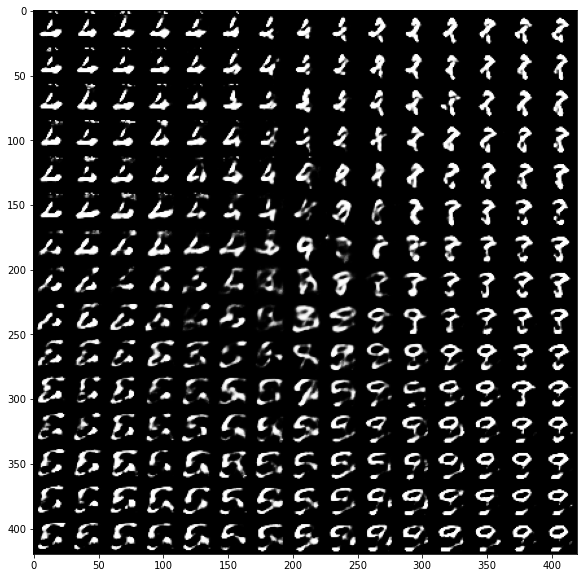

In [13]:
import matplotlib.pyplot as plt

# Display a grid of 15x15 digits (225 digits total)
n = 15
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

# Loop over each vector instead 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample_part = np.array([[xi, yi]]) 
        z_sample_random = np.random.normal(0, 1, (1, latent_dim - 2)) 
        z_sample = np.hstack((z_sample_part, z_sample_random))  
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.savefig(f"{result_dir}/digits_over_latent.png")